<a href="https://colab.research.google.com/github/SubhangiSati/Classification-of-Venomous-and-non-venomous-snakes/blob/main/snake_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Dataset paths
train_dir = '/content/drive/MyDrive/Snake Images/train'
test_dir = '/content/drive/MyDrive/Snake Images/test'

# Constants
img_width, img_height = 150, 150
batch_size = 32
epochs = 40
num_classes = 2

# Load and preprocess the dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Create the CNN model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_generator,
          steps_per_epoch=train_generator.samples // batch_size,
          epochs=epochs)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_acc)

# Predict class for an input image
def predict_image_class(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_width, img_height))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])

    if predicted_class == 0:
        return 'venomous'
    else:
        return 'non-venomous'

# Example usage
image_path = '/content/drive/MyDrive/Snake Images/test/Venomous/00550438.jpg'
predicted_class = predict_image_class(image_path)
print('Predicted class:', predicted_class)

Found 1430 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Epoch 1/40
44/44 [==============================] - 172s 4s/step - loss: 0.7130 - accuracy: 0.4964
Epoch 2/40
44/44 [==============================] - 100s 2s/step - loss: 0.6929 - accuracy: 0.5250
Epoch 3/40
44/44 [==============================] - 102s 2s/step - loss: 0.6929 - accuracy: 0.5150
Epoch 4/40
44/44 [==============================] - 101s 2s/step - loss: 0.6951 - accuracy: 0.5179
Epoch 5/40
44/44 [==============================] - 104s 2s/step - loss: 0.6878 - accuracy: 0.5393
Epoch 6/40
44/44 [==============================] - 105s 2s/step - loss: 0.6958 - accuracy: 0.5265
Epoch 7/40
44/44 [==============================] - 99s 2s/step - loss: 0.6909 - accuracy: 0.5258
Epoch 8/40
44/44 [==============================] - 102s 2s/step - loss: 0.6833 - accuracy: 0.5479
Epoch 9/40
44/44 [==============================] - 102s 2s/step - loss: 0.6816 - accuracy: 0.5300
Epoch 10/40
44/44 [========

ensemble of models by utilizing transfer learning with the VGG16 model as the base

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

# Dataset paths
train_dir = '/content/drive/MyDrive/Snake Images/train'
test_dir = '/content/drive/MyDrive/Snake Images/test'

# Constants
img_width, img_height = 150, 150
batch_size = 32
epochs = 10
num_classes = 2
num_models = 3  # Number of models in the ensemble

# Load and preprocess the dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Create the ensemble of models
ensemble_models = []
for _ in range(num_models):
    # Use VGG16 as the base model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification layers on top of the base model
    model = keras.Sequential([
        base_model,
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    ensemble_models.append(model)

# Train the ensemble models
for model in ensemble_models:
    model.fit(train_generator,
              steps_per_epoch=train_generator.samples // batch_size,
              epochs=epochs)

# Evaluate the ensemble models
ensemble_scores = []
for model in ensemble_models:
    _, acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
    ensemble_scores.append(acc)

# Average ensemble accuracy
ensemble_accuracy = np.mean(ensemble_scores)
print('Ensemble accuracy:', ensemble_accuracy)

# Predict class for an input image using the ensemble
def predict_image_class(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_width, img_height))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = np.zeros((num_classes,))
    for model in ensemble_models:
        predictions += model.predict(img_array)[0]

    predicted_class = np.argmax(predictions)

    if predicted_class == 0:
        return 'venomous'
    else:
        return 'non-venomous'

# Example usage
image_path = '/content/drive/MyDrive/Snake Images/test/Non Venomous/112282-850x565-Yellow_Rat_Snake.jpg'
predicted_class = predict_image_class(image_path)
print('Predicted class:', predicted_class)


Found 1430 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/40
44/44 [==============================] - 246s 5s/step - loss: 1.2732 - accuracy: 0.5544
Epoch 2/40
44/44 [==============================] - 247s 6s/step - loss: 0.5964 - accuracy: 0.6609
Epoch 3/40
44/44 [==============================] - 242s 5s/step - loss: 0.5616 - accuracy: 0.7003
Epoch 4/40
44/44 [==============================] - 243s 5s/step - loss: 0.5427 - accuracy: 0.7046
Epoch 5/40
44/44 [==============================] - 238s 5s/step - loss: 0.5171 - accuracy: 0.7289
Epoch 6/40
44/44 [==============================] - 243s 6s/step - loss: 0.5405 - accuracy: 0.7160
Epoch 7/40
44/44 [==============================] - 240s 5s/step - loss: 0.5286 - accuracy: 0.7260
Epoch 8/40
44/44 [==============================] - 240s 5s/step - loss: 0.5119 - accuracy: 0.7303
Epoch 9/40
44/44 [==============================] - 240s 5s/

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

# Dataset paths
train_dir = '/content/drive/MyDrive/Snake Images/train'
test_dir = '/content/drive/MyDrive/Snake Images/test'

# Constants
img_width, img_height = 150, 150
batch_size = 32
epochs = 10
num_classes = 2

# Load and preprocess the dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Use VGG16 as the base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
model = keras.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_generator,
          steps_per_epoch=train_generator.samples // batch_size,
          epochs=epochs)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_acc)

# Predict class for an input image
def predict_image_class(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_width, img_height))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])

    if predicted_class == 1:
        return 'venomous'
    else:
        return 'non-venomous'

# Example usage
image_path = '/content/drive/MyDrive/Snake Images/test/Non Venomous/10.jpg'
predicted_class = predict_image_class(image_path)
print('Predicted class:', predicted_class)


Found 1430 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Epoch 1/10
44/44 [==============================] - 270s 6s/step - loss: 1.2481 - accuracy: 0.5658


Found 1430 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Epoch 1/10
44/44 [==============================] - 65s 1s/step - loss: 0.6192 - accuracy: 0.6645 - val_loss: 0.3997 - val_accuracy: 0.8359
Epoch 2/10
44/44 [==============================] - 60s 1s/step - loss: 0.4368 - accuracy: 0.7926 - val_loss: 0.3666 - val_accuracy: 0.8320
Epoch 3/10
44/44 [==============================] - 61s 1s/step - loss: 0.3819 - accuracy: 0.8319 - val_loss: 0.3349 - val_accuracy: 0.8359
Epoch 4/10
44/44 [==============================] - 58s 1s/step - loss: 0.3548 - accuracy: 0.8405 - val_loss: 0.3752 - val_accuracy: 0.8242
Epoch 5/10
44/44 [==============================] - 58s 1s/step - loss: 0.3244 - accuracy: 0.8505 - val_loss: 0.3224 - val_accuracy: 0.8555
Epoch 6/10
44/44 [==============================] - 62s 1s/step - loss: 0.2972 - accuracy: 0.8741 - val_loss: 0.3000 - val_accuracy: 0.8594
Epoch 7/10
44/44 [==============================] - 60s 1s/step - loss: 0.270

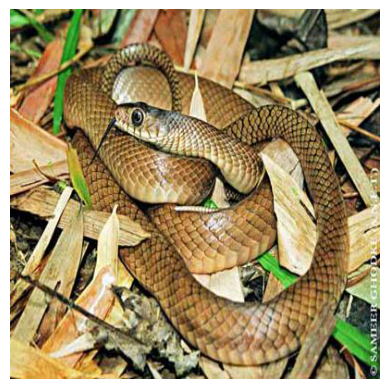

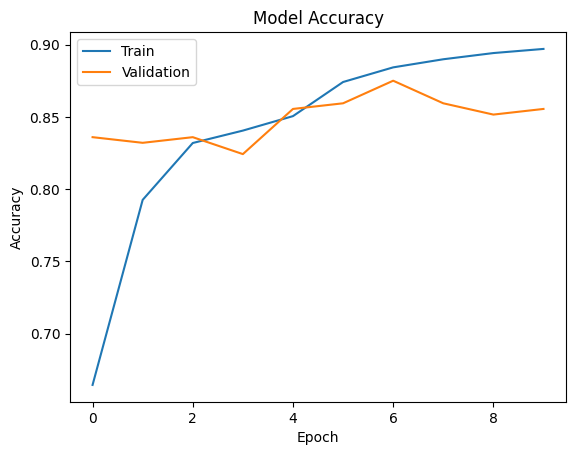

8/8 [==============================] - 9s 1s/step


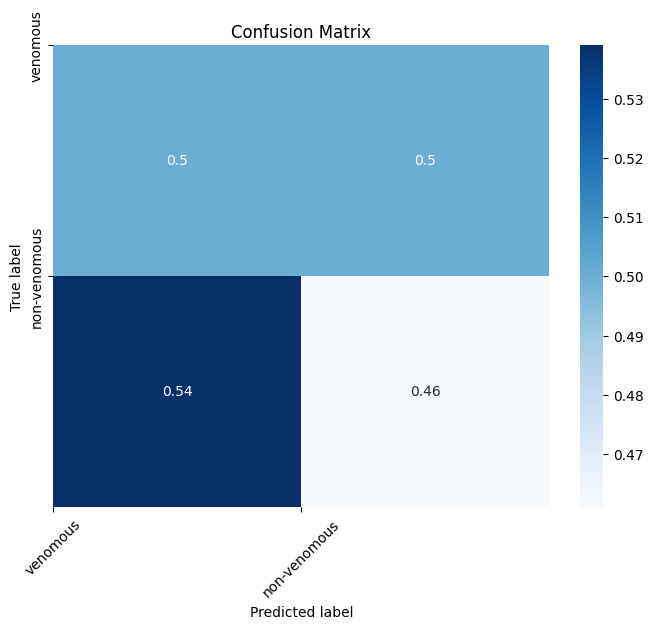

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Constants
img_width, img_height = 224, 224
batch_size = 32
num_classes = 2
epochs = 10

# Function to load and preprocess the dataset
def load_dataset(train_dir, test_dir):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, test_generator

# Function to create the model with transfer learning
def create_model():
    base_model = MobileNetV2(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False

    model = keras.Sequential([
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Function to plot the accuracy graph
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Function to draw a colored confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

# Function to predict the class for an input image
def predict_image_class(model, image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_width, img_height))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])

    if predicted_class == 1:
        return 'venomous'
    else:
        return 'non-venomous'

# Load the dataset
train_dir = '/content/drive/MyDrive/Snake Images/train'
test_dir = '/content/drive/MyDrive/Snake Images/test'
train_generator, test_generator = load_dataset(train_dir, test_dir)

# Create the model
model = create_model()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=test_generator.samples // batch_size)

# Calculate the accuracy of the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_acc)

# Predict class for an input image
image_path = '/content/drive/MyDrive/Snake Images/test/Non Venomous/1.jpg'
predicted_class = predict_image_class(model, image_path)
print('Predicted class:', predicted_class)

# Display the image
img = keras.preprocessing.image.load_img(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

# Plot the accuracy graph
plot_accuracy(history)

# Predict classes for the test dataset
test_generator.reset()
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Draw a colored confusion matrix
class_names = ['venomous', 'non-venomous']
plot_confusion_matrix(y_true, y_pred, class_names)


Found 1430 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Epoch 1/10
44/44 [==============================] - 50s 1s/step - loss: 0.6174 - accuracy: 0.6810 - val_loss: 0.3971 - val_accuracy: 0.8086
Epoch 2/10
44/44 [==============================] - 48s 1s/step - loss: 0.4350 - accuracy: 0.7890 - val_loss: 0.3611 - val_accuracy: 0.8281
Epoch 3/10
44/44 [==============================] - 53s 1s/step - loss: 0.3613 - accuracy: 0.8333 - val_loss: 0.3311 - val_accuracy: 0.8438
Epoch 4/10
44/44 [==============================] - 52s 1s/step - loss: 0.3392 - accuracy: 0.8433 - val_loss: 0.3219 - val_accuracy: 0.8633
Epoch 5/10
44/44 [==============================] - 53s 1s/step - loss: 0.3290 - accuracy: 0.8505 - val_loss: 0.3424 - val_accuracy: 0.8281
Epoch 6/10
44/44 [==============================] - 52s 1s/step - loss: 0.2620 - accuracy: 0.8898 - val_loss: 0.2922 - val_accuracy: 0.8945
Epoch 7/10
44/44 [==============================] - 53s 1s/step - loss: 0.274

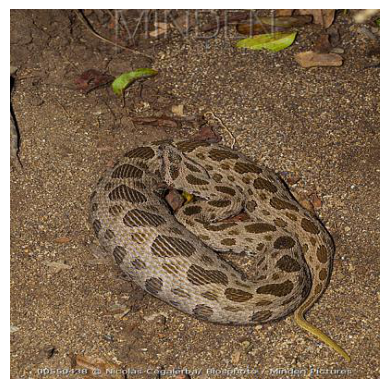

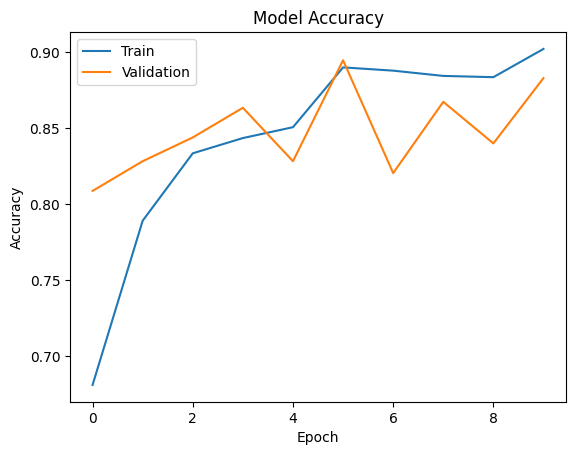

8/8 [==============================] - 6s 704ms/step


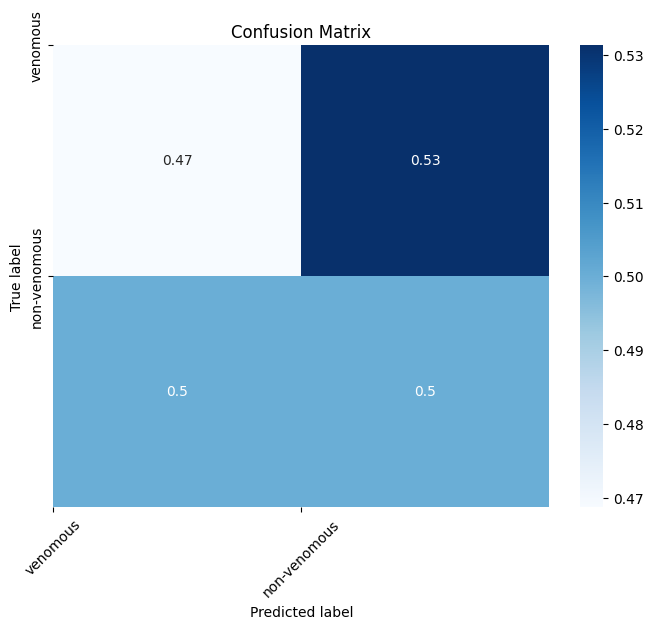

8/8 [==============================] - 7s 855ms/step
Classification Report:
              precision    recall  f1-score   support

    venomous       0.59      0.57      0.58       128
non-venomous       0.58      0.60      0.59       128

    accuracy                           0.59       256
   macro avg       0.59      0.59      0.59       256
weighted avg       0.59      0.59      0.59       256



In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


# Constants
img_width, img_height = 224, 224
batch_size = 32
num_classes = 2
epochs = 10

# Function to load and preprocess the dataset
def load_dataset(train_dir, test_dir):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, test_generator

# Function to create the model with transfer learning
def create_model():
    base_model = MobileNetV2(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False

    model = keras.Sequential([
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Function to plot the accuracy graph
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Function to draw a colored confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

# Function to predict the class for an input image
def predict_image_class(model, image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_width, img_height))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])

    if predicted_class == 1:
        return 'venomous'
    else:
        return 'non-venomous'

# Load the dataset
train_dir = '/content/drive/MyDrive/Snake Images/train'
test_dir = '/content/drive/MyDrive/Snake Images/test'
train_generator, test_generator = load_dataset(train_dir, test_dir)

# Create the model
model = create_model()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=test_generator.samples // batch_size)

# Calculate the accuracy of the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_acc)

# Predict class for an input image
image_path = '/content/drive/MyDrive/Snake Images/test/Venomous/00550438.jpg'
predicted_class = predict_image_class(model, image_path)
print('Predicted class:', predicted_class)

# Display the image
img = keras.preprocessing.image.load_img(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

# Plot the accuracy graph
plot_accuracy(history)

# Predict classes for the test dataset
test_generator.reset()
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Draw a colored confusion matrix
class_names = ['venomous', 'non-venomous']
plot_confusion_matrix(y_true, y_pred, class_names)
# Predict classes for the test dataset
test_generator.reset()
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Calculate evaluation metrics
report = classification_report(y_true, y_pred, target_names=class_names)
print('Classification Report:')
print(report)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
